In [1]:
%run ./_setup.ipynb

In [2]:
from matplotlib.path import Path
import scipy.interpolate

# Process bathymetry data

Here we download bathymetry of Galveston Bay, decimating by taking every 5th point in x and y so that it is easier to work with. After downloading the decimated data, it saves it to a local netcdf file (`data/bathy/topo.nc`). This process is pretty quick on a lightweight machine with decent internet connection. Note that this data is referenced to the vertical tidal datum of Mean High Water (MHW) and horizontal datum of World Geodetic System 1984 (WGS84).

The notebook saves the results of this processing for use in plots and analysis in a file called `data/bathy/bathy.nc`.

## Read in data over internet

In [3]:
# Create netCDF file of topography if it doesn't already exist
fname = baseb + 'topo.nc'

if not os.path.exists(fname):
    loc = 'https://www.ngdc.noaa.gov/thredds/dodsC/regional/galveston_13_mhw_2007.nc?crs,lat[0:5:10260],lon[0:5:10260],Band1[0:5:10260][0:5:10260]'
    ds = xr.open_dataset(loc)
    ds.to_netcdf(fname)
else:
    ds = xr.open_dataset(fname)

# rename variables and change to arrays
topo = ds['Band1'].values  # both topography and bathymetry
lon = ds['lon'].values
lat = ds['lat'].values

## Calculate cell lengths and convert to a projection

Use Albers Equal Area projection to reasonably preserve distance and match the projection of the watershed shapefiles. It is important to put the center of the projection near our area of interest.

We use the mean in each direction of the cell lengths since they are almost equal.

In [4]:
# create grid of lon/lat values
Lon, Lat = np.meshgrid(lon, lat)

# convert from lon/lat to x/y
pts = aea.transform_points(pc, Lon, Lat)
xp = pts[:,:,0]; yp  = pts[:,:,1]

# calculate average
dx = np.diff(xp, axis=1).mean()  # are all within about a meter of each other
dy = np.diff(yp, axis=0).mean()  # are all within about a meter of each other
print(dx,dy)

44.982302479 51.2904789579


## Remove topography

Change to nan any value above 0 since it is on load. Rename our new array to `bathy` to signify that it is only bathymetry.

In [5]:
inds = topo > 0
bathy = topo.copy()
bathy[inds] = np.nan

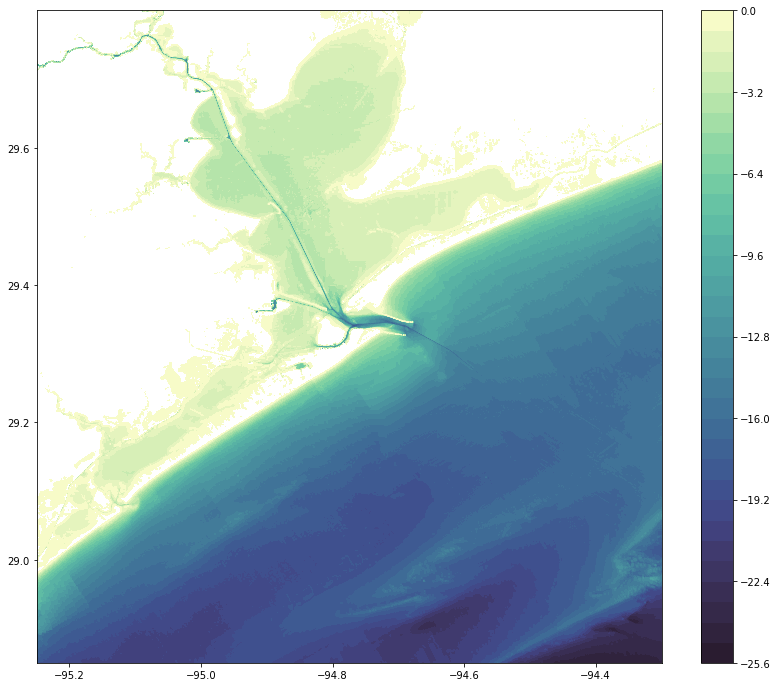

In [6]:
# now what does it look like
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathy, 40, cmap=cmo.deep_r); 
fig.colorbar(mappable)

## Define bay

Use watershed basins to define West Bay and Main Bay (includes East Bay).

In [7]:
twdbshapes = 'galv_ws_nad83_prj_albers_equal_area_conic_USGS'
fname = '%s%s/%s.shp' % (basesf, twdbshapes, twdbshapes)

In [8]:
# Define West Bay
iwest = [24240, 24320]  # in idgb
reader = cartopy.io.shapereader.Reader(fname)
basins = reader.records()

westbasins = []
for basin in basins:
    if basin.attributes['WS_ID'] in iwest:
        westbasins.append(basin)

# combine watersheds into 1 polygon
westbasin = shapely.ops.unary_union([westbasin.geometry for westbasin in westbasins])

# find x/y points in array that are within westbasin polygon
# convert to matplotlib path since way faster than shapely contains
xywest = np.array(westbasin.exterior.xy).T  # tuple to array to be Nx2
pathout = Path(xywest)
ibathywest = pathout.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)

# nan out non West Bay points to preserve array structure
bathywest = bathy.copy()
bathywest[~ibathywest] = np.nan

In [9]:
# Define Main Bay (includes East)
imain = [24260,24220,24210,24230,24250,24390]
reader = cartopy.io.shapereader.Reader(fname)

basins = reader.records()
mainbasins = []
for basin in basins:
    if basin.attributes['WS_ID'] in imain:
        mainbasins.append(basin)

# combine watersheds into 1 polygon. Need buffer because polygons do not fully intersect
mainbasin = shapely.ops.unary_union([mainbasin.geometry.buffer(300) for mainbasin in mainbasins])

# convert to matplotlib path since way faster than shapely contains (27 min vs. 50 seconds)
xymain = np.array(mainbasin.exterior.xy).T  # tuple to array to be Nx2
pathout = Path(xymain)
ibathymain = pathout.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)

# nan out non Main Bay points to preserve array structure
bathymain = bathy.copy()
bathymain[~ibathymain] = np.nan

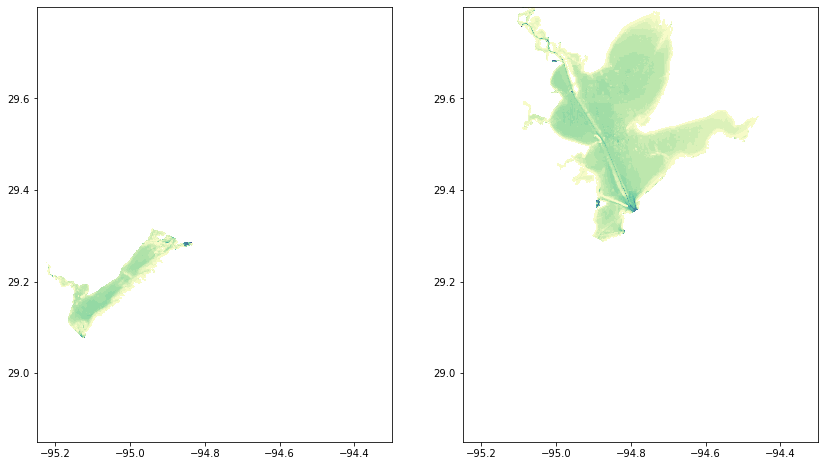

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
axes[0].contourf(lon, lat, bathywest, 40, cmap=cmo.deep_r); 
mappable = axes[1].contourf(lon, lat, bathymain, 40, cmap=cmo.deep_r); 

# Surface area, depth, volume

## All of Galveston Bay

Assuming that there wasn't a significant amount of new land flooded.

In [11]:
# surface area
A = np.nansum(~np.isnan(bathymain)*dx*dy) + np.nansum(~np.isnan(bathywest)*dx*dy)  # m^2

# average depth
H = -np.nanmean(bathymain + bathywest)  # m

# average volume
Vall = (A*H)/1000**3  # km^3

print('Full bay area: %d km^2, average depth: %2.2f m, volume: %2.2f km^3' % (A/(1000**2), H, Vall))

Full bay area: 1393 km^2, average depth: 3.65 m, volume: 5.09 km^3


## Main bay

In [12]:
# surface area
A = np.nansum(~np.isnan(bathymain)*dx*dy)  # m^2

# average depth
H = -(np.nansum(bathymain))/((~np.isnan(bathymain)).sum())  # m

# average volume
V = (A*H)/1000**3  # km^3

print('Main bay area: %d km^2, average depth: %2.2f m, volume: %2.2f km^3' % (A/(1000**2), H, V))

Main bay area: 1190 km^2, average depth: 2.48 m, volume: 2.95 km^3


## West Bay

In [13]:
# surface area
A = np.nansum(~np.isnan(bathywest)*dx*dy)  # m^2

# average depth
H = -(np.nansum(bathywest))/((~np.isnan(bathywest)).sum())  # m

# average volume
V = (A*H)/1000**3  # km^3

print('West bay area: %d km^2, average depth: %2.2f m, volume: %2.2f km^3' % (A/(1000**2), H, V))
print('The West Bay volume is %2d%% of the full bay volume' % (V/Vall*100))

West bay area: 202 km^2, average depth: 1.51 m, volume: 0.31 km^3
The West Bay volume is  6% of the full bay volume


# Cross-sectional Area of Entrance Channel

Calculate a few numbers describing the approximate cross-sectional area of the Galveston Bay entrance channel, for use in evaluating the final inflow result.

We select the cross-sectional slice in lat/lon out of convenience since the slice is easy to define.

In [14]:
bathynotbay = bathy.copy()
ilonchannel = (lon < -94.7) * (lon > -94.83)
ilatchannel = (lat > 29.32) * (lat < 29.38)
# combined array of indices to target entrance channel area
illchannel = np.outer(ilonchannel, ilatchannel)
bathynotbay2 = bathynotbay[illchannel]

# setup up input data, needs to be Nx2
xyin = np.vstack((xp[illchannel].flat, yp[illchannel].flat)).T

# can choose slice in lat/lon but then interpolate in projection
latslice = np.linspace(29.33, 29.38, 400)
lonslice = np.ones(latslice.size)*buoys['g06010']['ll'][0]

# transform slice to projection
pts = aea.transform_points(pc, lonslice, latslice)

# need it to be Nx2
aeaslice = np.vstack((pts[:,0].flat, pts[:,1].flat)).T

# do the interpolation
Zslice = scipy.interpolate.griddata(xyin, bathynotbay2.flat, aeaslice, method='linear', fill_value=0)

In [15]:
# only keep depths within any nans since jetty is in there too
# also remove below 4m since channel widens on ebb and flow may not fill in that area
ichannel = np.arange(60,225)  # indices to keep

# average depth across channel
Hcs = abs(Zslice[ichannel].mean())
print('Average cross-channel depth: %2.1fm' % Hcs)

# distance across channel
dist = np.sqrt((pts[ichannel,0] - pts[ichannel[0],0])**2 + (pts[ichannel,1] - pts[ichannel[0],1])**2)
print('Cross-channel distance: %2.1fkm' % (dist[-1]/1000))

# calculate dslice distance between points along cross-sectional area
dslice = np.diff(dist).mean()

# constant cross-sectional area to MHW
Acs0 = abs(Hcs*dist[-1])
print('Constant cross-sectional area: %2.0f m^2' % Acs0)

Average cross-channel depth: 11.3m
Cross-channel distance: 2.3km
Constant cross-sectional area: 25738 m^2


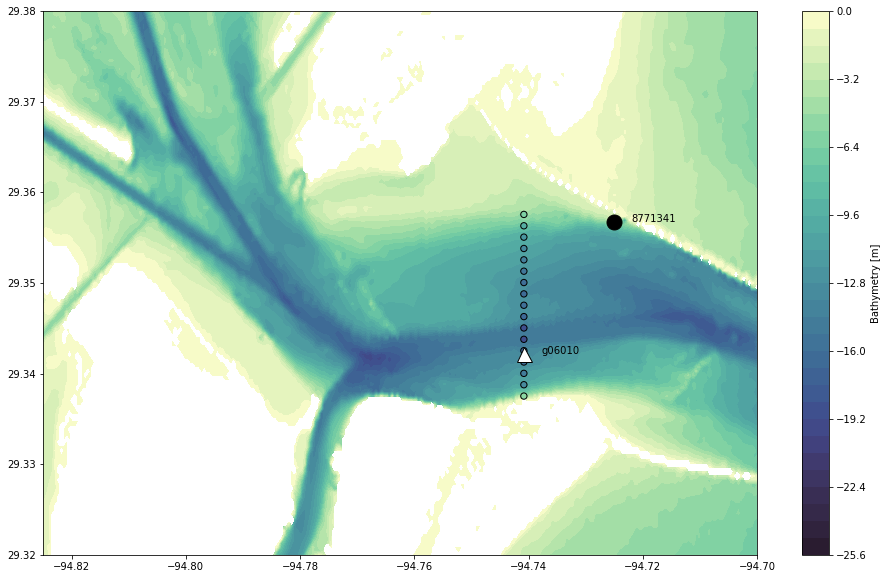

In [16]:
# check interpolation
fig, ax = plt.subplots(1,1, figsize=(16,10))

mappable = ax.contourf(lon, lat, bathynotbay, 40, cmap=cmo.deep_r); 
ax.set_ylim(29.32, 29.38)
ax.set_xlim(-94.825,-94.7)

# velocity station
ax.plot(*buoys['g06010']['ll'], '^', markersize=15, mfc='w', mec='k')
ax.text(buoys['g06010']['ll'][0]+0.003, buoys['g06010']['ll'][1], 'g06010')

ax.plot(*buoys['8771341']['ll'], 'ko', markersize=15)
ax.text(buoys['8771341']['ll'][0]+0.003, buoys['8771341']['ll'][1], '8771341')

cb = fig.colorbar(mappable)
cb.set_label('Bathymetry [m]')

dd = 10  # skip some to plot
ax.scatter(lonslice[ichannel][::dd], latslice[ichannel][::dd], c=Zslice[ichannel][::dd], s=40, cmap=cmo.deep_r, 
           vmin=-20, vmax=0, edgecolor='k')

# Save file

Add these new variables to the dataset and save to a netCDF file.

In [17]:
fname = baseb + 'bathy.nc'
if not os.path.exists(fname):

    # drop old variable
    ds = ds.drop('Band1')

    # add new bathy arrays
    ds['all'] = (('lat','lon'), bathy)  # data with topo nan'ed out
    ds['main'] = (('lat','lon'), bathymain)  # bathy in main and east bays
    ds['west'] = (('lat','lon'), bathywest)  # bathy in west bay
    # have masked array for plotting at boundary between land and water
    ds['mask'] = (('lat','lon'), np.ma.masked_where(topo>0, topo).mask)

    # add in scalars
    ds.attrs['Acs0'] = Acs0  # cross-sectional area of entrance channel
    ds.attrs['Dcs'] = dist[-1]  # distance across the entrance channel
    ds.attrs['dx'] = dx  # delta distance in x direction, meters
    ds.attrs['dy'] = dy  # delta distance in y direction, meters

    # save netcdf file
    ds.to_netcdf(fname)